calculating midline
midline calculated
optimisation commencing
path optimised
profiling commencing


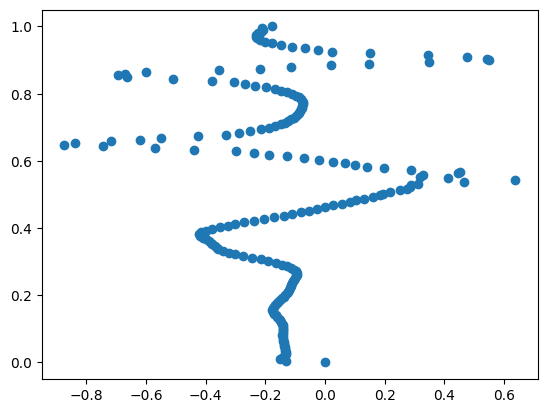

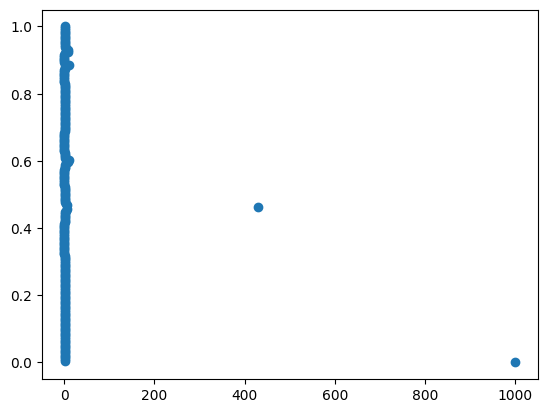

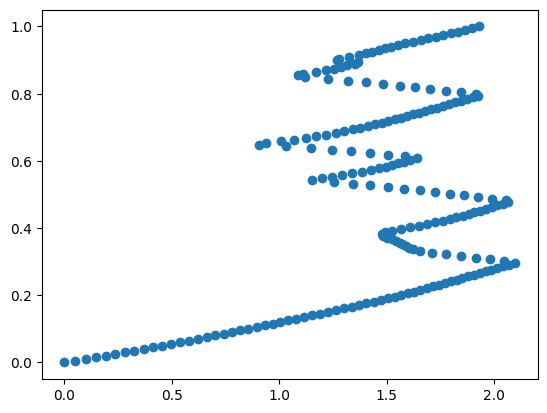

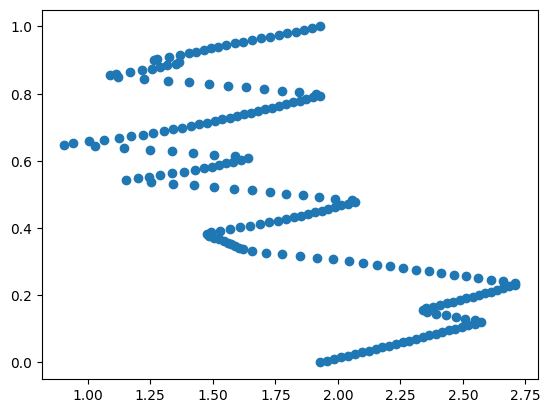

Path length: 8.756686038906121
-0.00271038169005687 1.1345625214137347
0.0008564883983138553
trajectory profiled


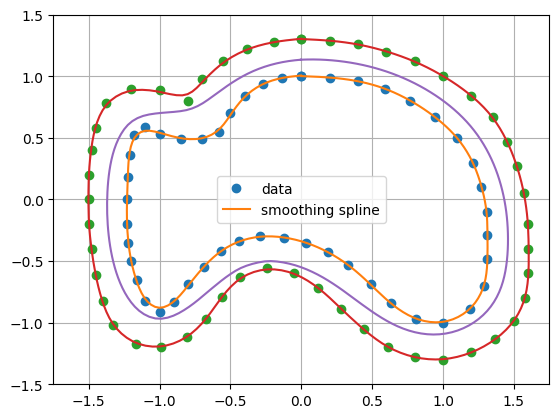

In [1]:
import sys
import os
sys.path.insert(1, "/Users/alistair/Projects/Dissertation/Jenson/src")
from  Models.track import Track
from Models.robot import Robot
from Utils.state import State
import config

car = Robot()

path = os.path.join(config.SRC_PATH, "JSON/track.json")
track = Track.from_json(config.SRC_PATH + "/JSON/track.json", car)

trajectory = track.trajectories[1]

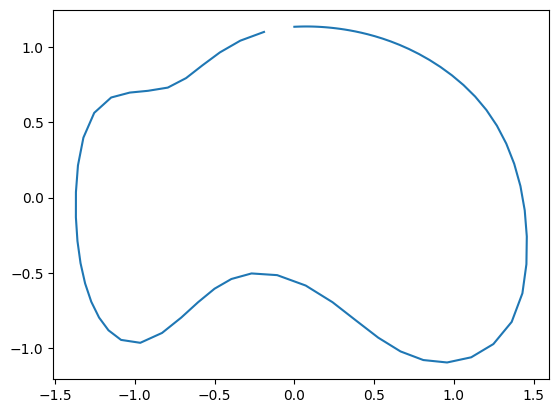

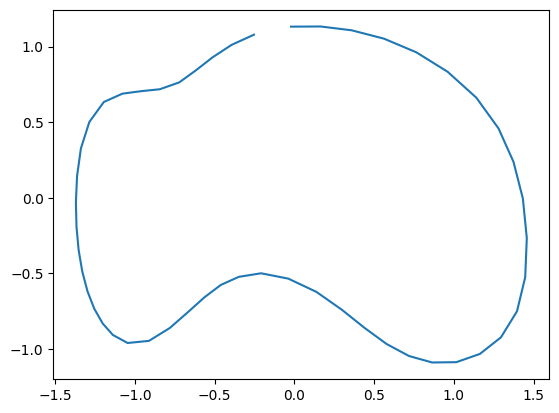

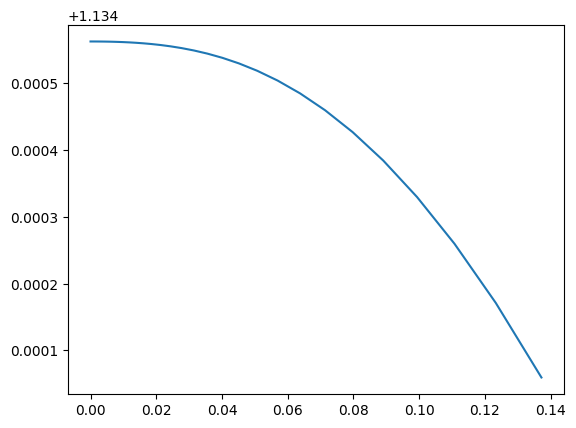

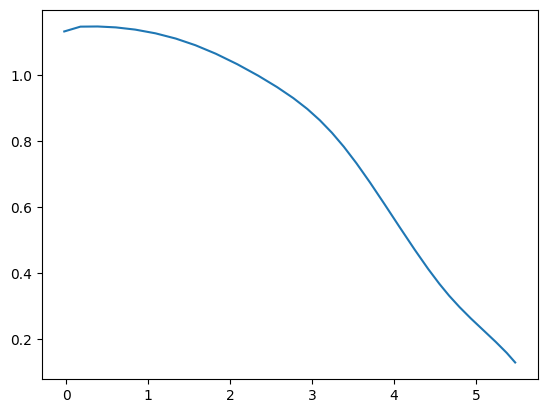

In [2]:
#plot the trajectory
trajectory0 = track.trajectories[0]
trajectory1 = track.trajectories[1]

trajectory0.plot_states()
trajectory1.plot_states()
trajectory0.plot_actions()
trajectory1.plot_actions()


In [3]:
# Create a function to generate a localisation state by adding noise to a random state from the trajectory
import random

def add_noise(old_state, noise):
    state = old_state.copy()

    state.x += random.uniform(-noise, noise)
    state.y += random.uniform(-noise, noise)
    state.v = float(state.v)
    state.w = float(state.w)
    state.theta += random.uniform(-noise, noise)
    return state


def generate_localisation_state(trajectory, noise):
    state = trajectory.states[random.randint(0, len(trajectory.states) - 1)]
    state = add_noise(state, noise)
    return state

def generate_localisation_states(trajectory, noise, num_states):
    states = []
    for i in range(num_states):
        state = generate_localisation_state(trajectory, noise)
        states.append(state)
    return states

localisation_states = generate_localisation_states(trajectory0, 0.25, 30)

In [4]:
# Start a controller using track.trajectories

from Control.controller import MPCController

controller = MPCController(car, track.trajectories)

# function to generate control from localisation input

def generate_control(controller: MPCController, localisation_states: list[State]):
    controls = []
    for state in localisation_states:
        control = controller.run(state)
        controls.append(control)
    return controls

In [6]:
#Generate controls
controls = generate_control(controller, localisation_states)

# Plot the controls in orange on top of the trajectory
# start a plot
import matplotlib.pyplot as plt
from Utils.action import Action


traj_x = [state.x for state in trajectory0.states]
traj_y = [state.y for state in trajectory0.states]

def compute_states(states, controls: list[Action]):
    cont_xs = []
    cont_ys = []
    for i in range(len(states)):
        cont_x =[]
        cont_y = []
        state = states[i]
        control = controls[i]
        cont_x.append(state.x)
        cont_y.append(state.y)
        for j in range(len(control)):
            new_state = control[j].apply(state)
            cont_x.append(new_state.x)
            cont_y.append(new_state.y)
            state = new_state
        cont_xs.append(cont_x)
        cont_ys.append(cont_y)
        
    return cont_xs, cont_ys



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.7520551e+16 0.00e+00 9.78e+10  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [ ]:
cont_xs, cont_ys = compute_states(localisation_states, controls)

plt.plot(traj_x, traj_y)

import numpy as np

for i in range(len(cont_xs)):
    print(cont_xs[i])
    x = np.array(cont_xs[i])
    y = np.array(cont_ys[i])

    plt.plot(x, y, color="orange")

plt.show()